# Dashboard plot

Given our nice RGB image registration, question now is how we can connect our element maps to color segmentation to arrive at conclusions for our palette.

%pip install -U git+https://github.com/fligt/maxrf4u.git

In [1]:
from glob import glob
import maxrf4u
import maxrf4u as mx
import os 
import re
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec

import skimage.exposure as ske
import moseley as mos

In [5]:
os.chdir('/media/frank/lonprojecten/2024-811_falnama-project/') 
print(f'maxrf4u: {mx.__version__}')

maxrf4u: 0.1.42


In [6]:
datastack_files = glob('data/interim/maxrf/datastacks/*.datastack')
datastack_files

['data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-13_400_600_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-17_400_600_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-18_400_300_50_det.datastack',
 'data/interim/maxrf/datastacks/WM-71803-18_400_500_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-19_400_600_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-23_400_600_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-24_400_600_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-29_400_500_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-30_250_300_50.datastack',
 'data/interim/maxrf/datastacks/WM-71803-31_400_600_50.dat

In [7]:
for i, dsf in enumerate(datastack_files):
    print(i, dsf)

0 data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack
1 data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack
2 data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack
3 data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack
4 data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack
5 data/interim/maxrf/datastacks/WM-71803-13_400_600_50.datastack
6 data/interim/maxrf/datastacks/WM-71803-17_400_600_50.datastack
7 data/interim/maxrf/datastacks/WM-71803-18_400_300_50_det.datastack
8 data/interim/maxrf/datastacks/WM-71803-18_400_500_50.datastack
9 data/interim/maxrf/datastacks/WM-71803-19_400_600_50.datastack
10 data/interim/maxrf/datastacks/WM-71803-23_400_600_50.datastack
11 data/interim/maxrf/datastacks/WM-71803-24_400_600_50.datastack
12 data/interim/maxrf/datastacks/WM-71803-29_400_500_50.datastack
13 data/interim/maxrf/datastacks/WM-71803-30_250_300_50.datastack
14 data/interim/maxrf/datastacks/WM-71803-31_400_600_50.datastack
15 data/interim/

In [8]:
n = 0 
datastack_file = datastack_files[n]
object_num = re.sub(r'.*(WM[^_]+).*', r'\g<1>', datastack_file)
ds = mx.DataStack(datastack_file)
ds.tree()

/
├── compton_peak_energy (1,) float64
├── hotmax_baselines (32, 4096) float64
├── hotmax_noiselines (32, 4096) float64
├── hotmax_peak_idxs_flat (33,) int64
├── hotmax_peak_idxs_list (32, 2) int64
├── hotmax_spectra (32, 4096) float32
├── hotmax_spots (32, 2) int64
├── hotmax_subpeak_idxs_list (32, 19) int64
├── imvis_extent (4,) int64
├── imvis_reg (583, 355, 3) uint8
├── imvis_reg_ (583, 355, 3) uint8
├── imvis_reg_highres (8256, 5027, 3) uint8
├── imvis_reg_highres_ (8256, 5027, 3) uint8
├── maxrf_cube (583, 355, 4096) float32
├── maxrf_energies (4096,) float64
├── maxrf_maxspectrum (4096,) float32
├── maxrf_sumspectrum (4096,) float64
├── nmf_atomnums (18,) int64
├── nmf_elementmaps (18, 583, 355) float32
├── nmf_gausscomponents (34, 4096) float32
├── nmf_peakmaps (34, 583, 355) float32
└── nmf_peaks2elements_matrix (18, 33) float32

data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack:




%matplotlib widget

In [9]:
imvis = ds.read('imvis_reg')
imvis_highres = ds.read('imvis_reg_highres')
extent = ds.read('imvis_extent')

In [10]:
element_maps = ds.read('nmf_elementmaps')
elements = mx.elems_from_atomnums(ds.read('nmf_atomnums'))

In [11]:
len(elements)

18

In [12]:
print(elements)

['S', 'Ag', 'K', 'Ca', 'Ba', 'Ti', 'Cr', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'Au', 'Hg', 'As', 'Pb', 'Sr', 'Zr']


Due to **The potassium problem**, we now have become aware that we should not trust computed element maps if the hotmax atlas does not contain a corresponding alpha peak. Let's check all elements...

In [13]:
print(mx.EOI)

['#H', '#He', '#Li', '#Be', '#B', '#C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', '#Ar', 'K', 'Ca', '#Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', '#Ga', '#Ge', 'As', '#Se', 'Br', '#Kr', '#Rb', 'Sr', '#Y', '#Zr', '#Nb', '#Mo', '#Tc', '#Ru', 'Rh', '#Pd', 'Ag', 'Cd', '#In', 'Sn', '#Sb', '#Te', 'I', '#Xe', '#Cs', 'Ba', '#La', '#Hf', '#Ta', '#W', '#Re', '#Os', '#Ir', '#Pt', 'Au', 'Hg', '#Tl', 'Pb', '#Bi', '#Po', '#At', '#Rn', '#Fr', '#Ra', '#Ac', '#Rf', '#Db', '#Sg', '#Bh', '#Hs', '#Mt', '#Ds', '#Rg', '#Cn', '#Nh', '#Fl', '#Mc', '#Lv', '#Ts', '#Og']


In [14]:
ppa = mx.Peak_Pattern_Atlas(elements_of_interest=None, datastack_file=datastack_file)
ppa.update_eoi(['Zr', 'Ar'])
hma = mx.HotmaxAtlas(datastack_file)
ds = mx.DataStack(datastack_file)

Please wait while initializing peak pattern atlas...


In [15]:
trusted = [bool(hma.finder(elem)) for elem in elements]

In [16]:
print(trusted)

[True, True, False, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True]


We also need to locate the corresponding hotmax pixel and spectrum for each element. An example here is mercury. How can we explain the Hg map?  

In [17]:
plt.close('all')

%matplotlib widget

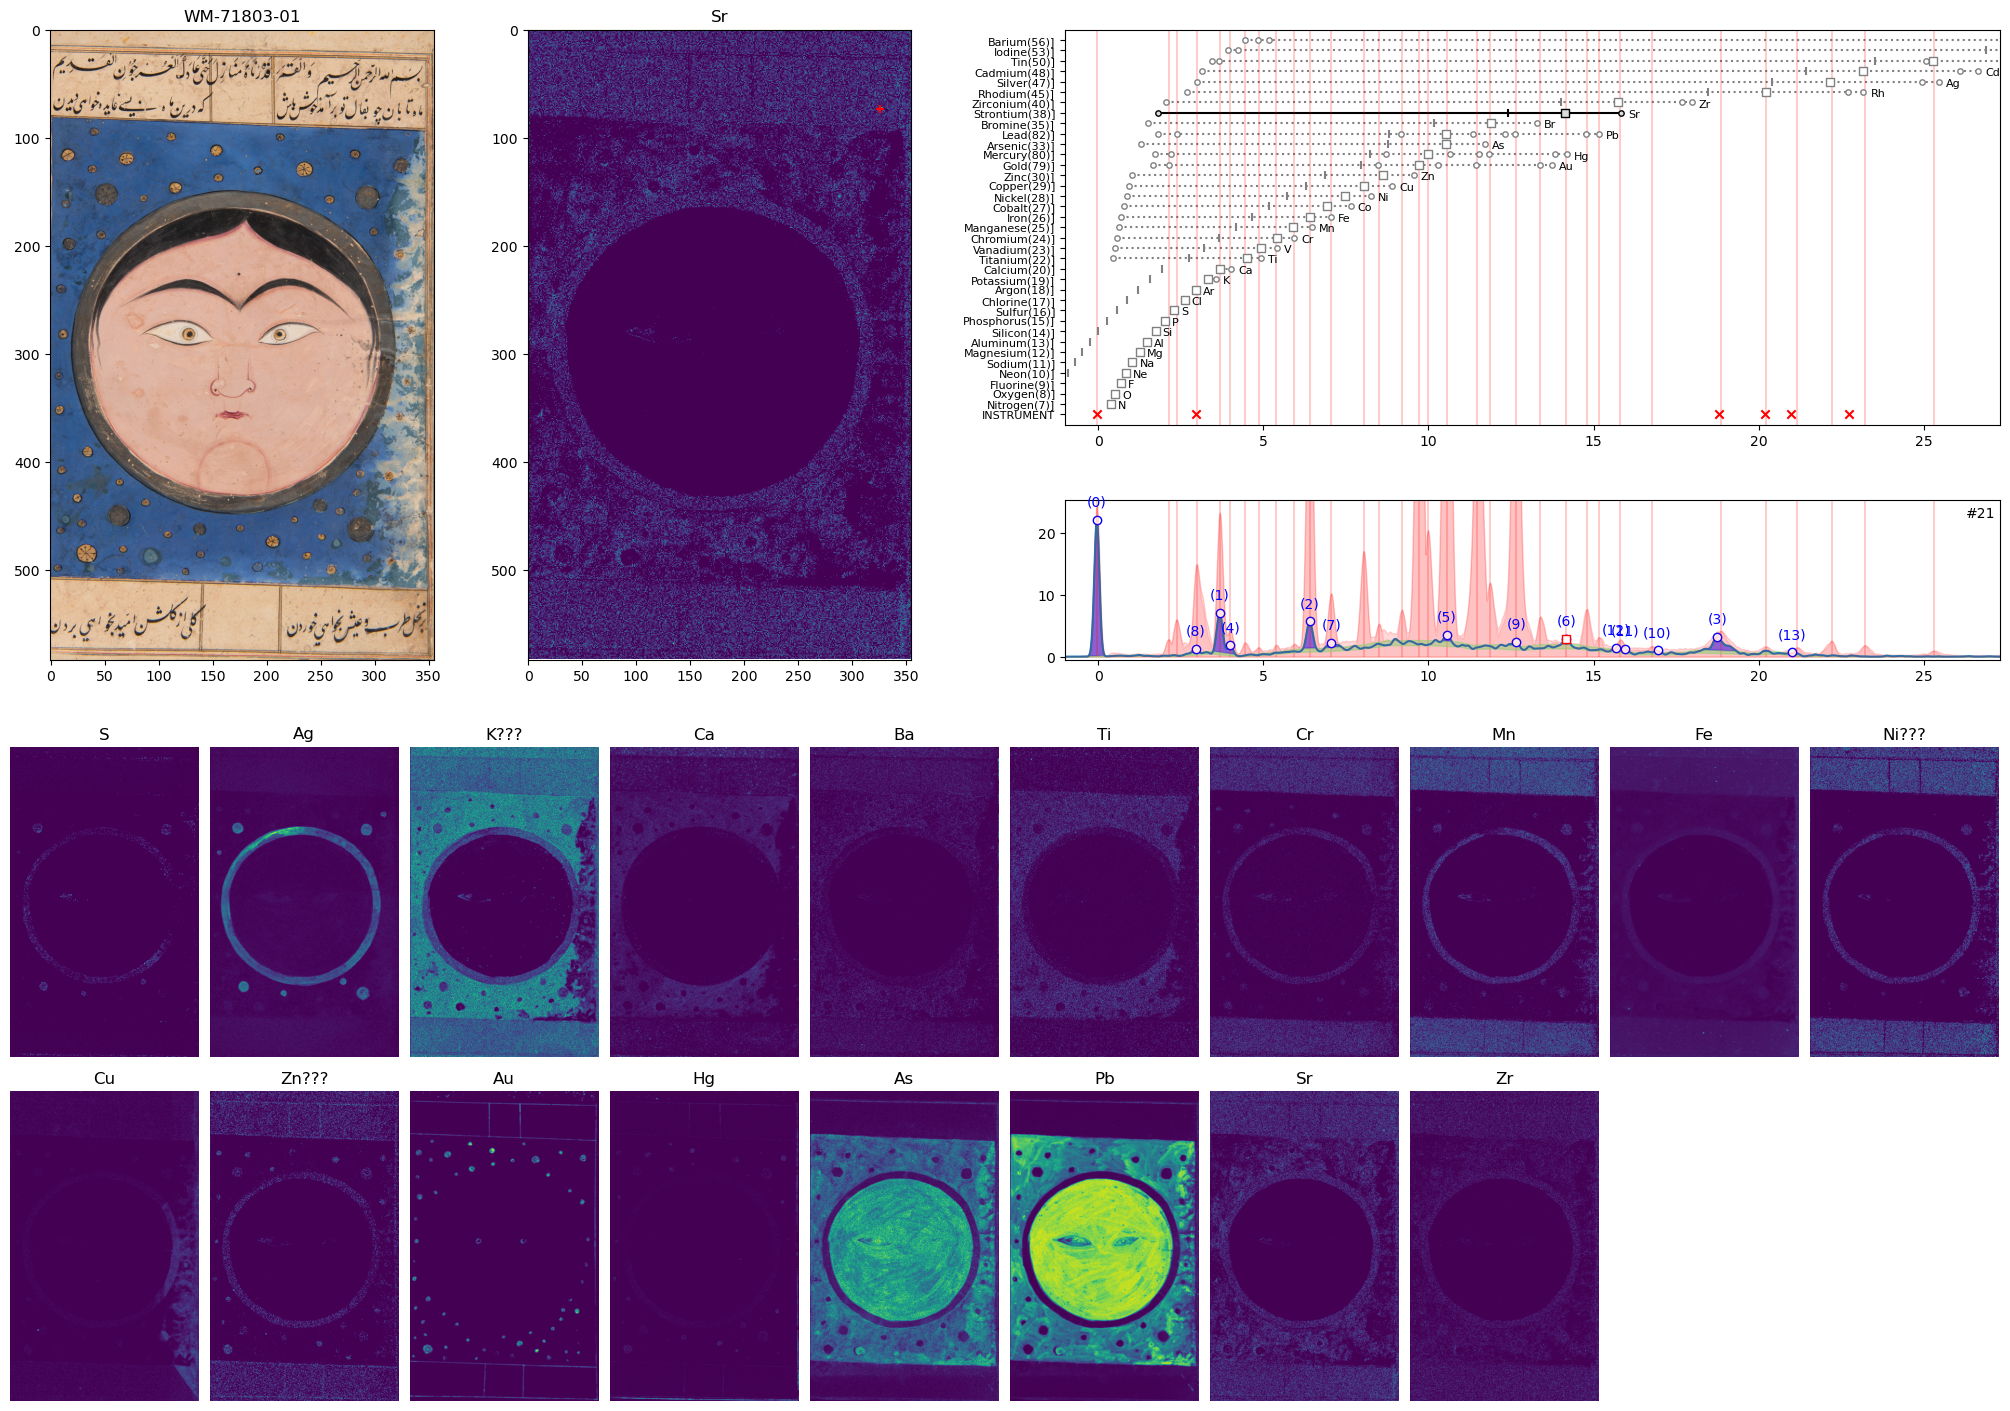

In [18]:
elem = 'Sr'
equalize = False

fig = plt.figure(layout='constrained', figsize=(20, 14))
top_fig, bot_fig = fig.subfigures(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.05)

# initialize subfigures and axes 
top_gs = GridSpec(figure=top_fig, nrows=3, ncols=4)
ax0 = top_fig.add_subplot(top_gs[:, 0])
ax1 = top_fig.add_subplot(top_gs[:, 1])
ax2 = top_fig.add_subplot(top_gs[0:2, 2:])
ax3 = top_fig.add_subplot(top_gs[2, 2:])


ax1.sharex(ax0)
ax1.sharey(ax0)

ax3.sharex(ax2)

bot_axs = bot_fig.subplots(ncols=10, nrows=2)
bot_axs = bot_axs.flatten() 

for ax in bot_axs: 
    ax.set_axis_off()

# rgb
ax0.imshow(imvis_highres, extent=extent)
ax0.set_title(object_num)

# selected element map
if equalize: 
    ax1.imshow(ske.equalize_hist(element_maps[elements.index(elem)]))
else: 
    ax1.imshow(element_maps[elements.index(elem)])
ax1.set_title(elem) 
#ax1.scatter(x, y, color='r', marker='+')

# spectral stuff 
ppa.plot_patterns(ax=ax2, select_elems=[elem])
n = hma.finder(elem)
if n: 
    hma.plot_spectrum(n, ax=ax3)
    hotmax_spots = ds.read('hotmax_spots')
    y, x = hotmax_spots[n]
    ax1.scatter(x, y, color='r', marker='+')
    

# bottom plots     
for i, [ax, emap] in enumerate(zip(bot_axs, element_maps)):
    ax.imshow(emap)
    if trusted[i]: 
        status = ''
    else: 
        status = '???'
        
    ax.set_title(elements[i] + status)



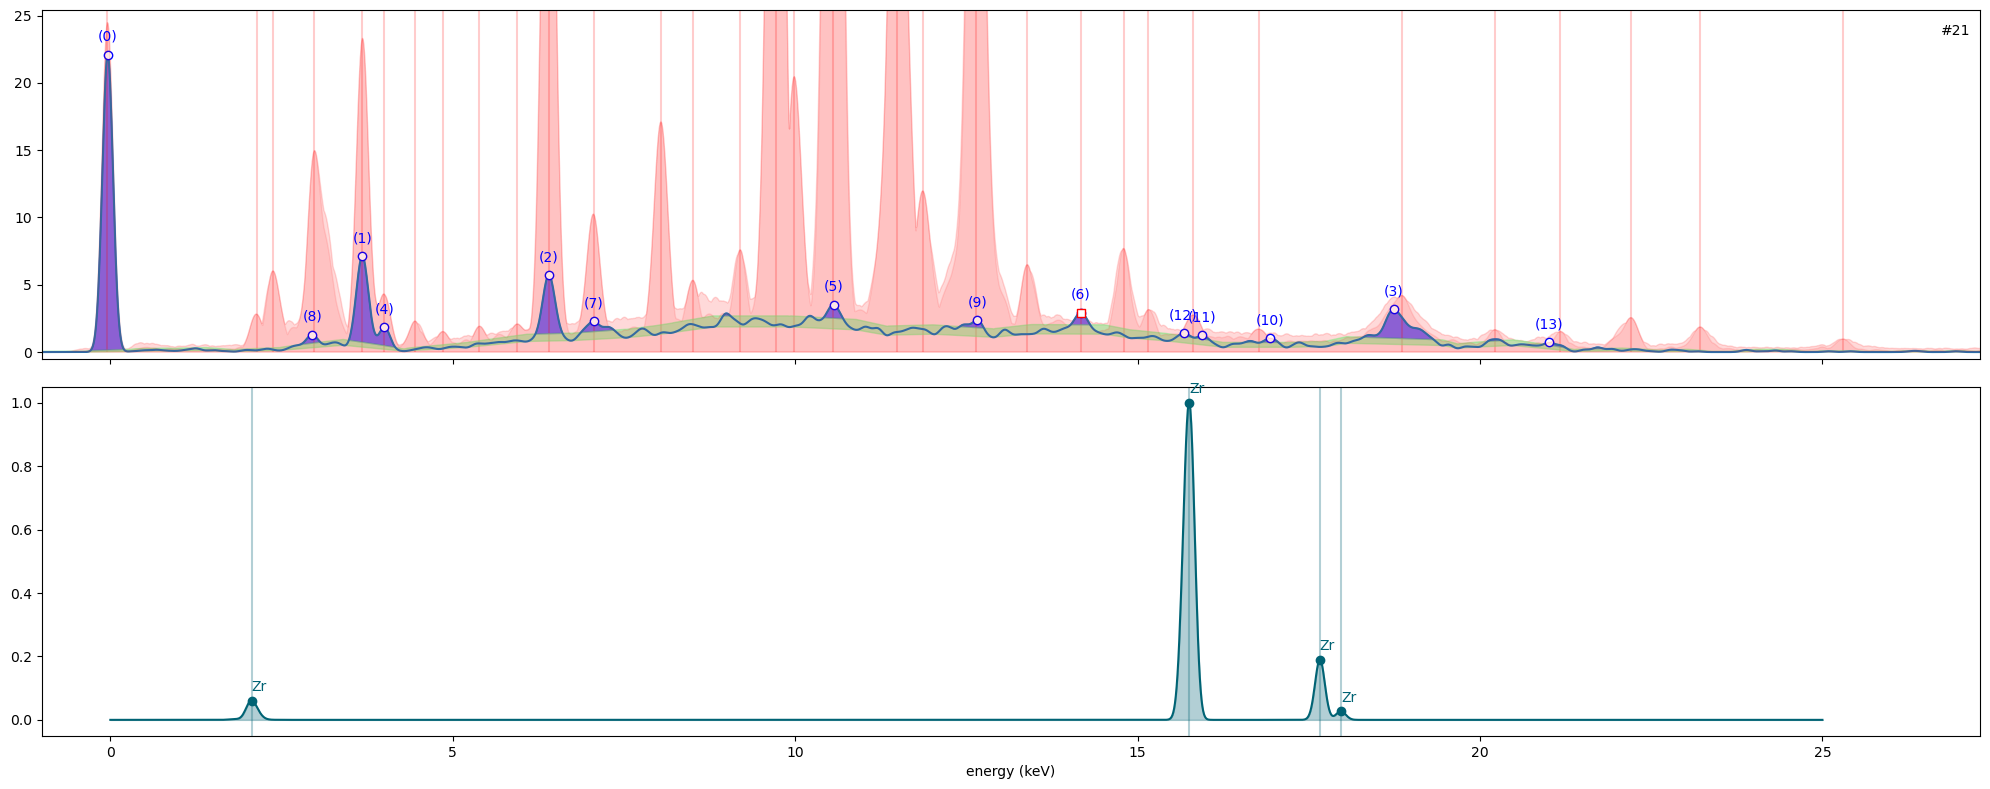

In [16]:
elems = ['Zr']

xfs = [mos.XFluo(elem, tube_keV=25) for elem in elems]

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=[20, 8])
ax0, ax1 = axs.flatten()

hma.plot_spectrum(n, ax=ax0)

for [xf, elem] in zip(xfs, elems): 
    xf.plot(ax=ax1)
